# Strong Lensing in Twinkles

## Overview

Strong Lensing in Twinkles simulations involves taking existing CATSIM instance catalogs and replacing specific AGN within those catalogs with a Strongly Lensed AGN system. This means adding images of the original AGN and a lens galaxy into the CATSIM instance catalogs. This is done using a piece of code in the Twinkles repository that is known as the sprinkler. This notebook will first discuss the sprinkler and then move onto verifying its outputs in instance catalogs.

## Sprinkler Code Review

The sprinkler code can be found [here](https://github.com/DarkEnergyScienceCollaboration/Twinkles/blob/master/python/desc/twinkles/sprinkler.py). It involves a step inserted into the `final pass` method of the Instance Catalog class that allows manipulation of the array of catalog results to be manipulated before printing out. This step starts with the loading of an OM10 based catalog of strongly lensed AGN systems.

### The OM10-Twinkles Catalog

The catalog we are using started with the set of the 872 rung 4 lenses from the Time Delay Challenge 1 (see discussion in this [issue](https://github.com/DarkEnergyScienceCollaboration/Twinkles/issues/117) on why these were chosen). However, when looking through this catalog we learned that sizes were missing for the foreground lens galaxies and we have chosen to use CATSIM galaxies to add this information to the catalog as well as an SED for each of these foreground galaxies. This process was completed in this [issue](https://github.com/DarkEnergyScienceCollaboration/Twinkles/issues/310). In the process 11 galaxies were unable to be matched adequately to CATSIM galaxies so we end up with a final catalog in Twinkles of 861 galaxies.

### Selecting Sprinkled Systems

The next step after loading the lensing catalog is to go through the instance catalog AGNs one at a time and see if they match a lens system from our OM10-Twinkles catalog. The matching is done by taking the redshift and magnitude of the CATSIM AGN and selecting any available lens systems with a source AGN that has a redshift within 0.1 dex and an LSST magnorm value (magnitude in a simulated filter with one bin at 500nm) within .25 mags.

Once the possible matches to a given instance catalog AGN are found there is a chance that it will be replaced that is set by the density parameter in the sprinkler class. In the current Twinkles run it is set at 1.0 so that 198 lens systems are sprinkled into the Twinkles instance catalogs.

If the AGN is chosen to be sprinkled then we proceed with the sprinkler and if there are multiple matches from the OM10-Twinkles catalog we randomly choose one to use as we proceed. First, we remove any disc and bulge information for that galaxy from the instance catalog leaving only the AGN data and copy this AGN entry creating 2 or 4 entries in the catalog depending upon the number of images the OM10 system we are sprinkling in has in total. Next we use the OM10 data for each image to shift the location of the AGN in each image to the correct location and adjust the magnitude for each entry depending on the OM10 magnification parameter for each AGN image. At this point we also adjust the time delay for each image with OM10 info and give all the images the same source redshift from the OM10 entry. Once the new entries are ready they are appended to the instance catalog with a new instance catalog id tag that gives us the ID of the Bulge galaxy in the instance catalog to which it is associated and the ID number of the OM10-Twinkles catalog system that is used.

The next step is to take the original entry in the instance catalog and add in the information for the foreground lens galaxy. Therefore, in this step the AGN and Disc data for the original galaxy are cleared and the redshift and magnitude for the lens galaxy from the OM10 system is added into the instance catalog. Here we also add in the radius of the lens galaxy and the sed file we want to use (the information added to the original OM10 systems in the process described in the last section). We also add in the OM10 position angles and ellipticities at this point.

Once we have gone through this process for all AGN in the instance catalog then we return to the normal instance catalog processing to write the information out to file.

## Verifying Instance Catalog Output

For the sections below I am using the output from an instance catalog created using Twinkles and removing the SNe entries at the bottom. I then split it up into the bulge+disk galaxy entries and the AGNs available for download [here](https://gist.github.com/jbkalmbach/3f7f2bbee5c2994a57ef55bb7f5f6419) and [here](https://gist.github.com/jbkalmbach/1105f16f8c55e82801deb8b4eb6b4ffb), respectively.

### Loading datasets

Before we begin we will load up the OM10-Twinkles catalog of lens systems and then the instance catalog information referenced above and add some columns to connect them all together.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
plt.style.use('ggplot')
%matplotlib inline

In [2]:
om10_cat = fits.open('../../data/twinkles_lenses_v2.fits')[1].data
galaxy_cat = pd.read_csv('phosim_galaxy_230.txt', delimiter=' ', usecols=(1, 2, 3, 4, 6, 13, 14), 
                         names=['id', 'ra', 'dec', 'mag_norm', 'redshift', 'major_axis', 'minor_axis'])
agn_cat = pd.read_csv('phosim_agn_230.txt', delimiter=' ', usecols=(1, 2, 3, 4, 6), names=['id', 'ra', 'dec', 'mag_norm', 'redshift'])

Now, we will cut on id numbers larger than a certain size. During the sprinkling process as new id numbers are given to the sprinkled AGN all of their ids are larger than 1e11 while those unsprinkled are not. We will also take the information contained in these larger ids and add columns containing the bulge id number and the om10 catalog id number.

In [3]:
sprinkled_agn = agn_cat.query('id > 1e11').reset_index(drop=True)

In [4]:
twinkles_id = []
im_num = []
lens_gal_id = []
for id_num in sprinkled_agn['id']:
    shift_id = np.right_shift(id_num, 10)
    twinkles_id.append(int(str(shift_id)[-4:])/4)
    im_num.append(int(str(shift_id)[-4:]) % 4)
    lens_gal_id.append(np.left_shift(np.right_shift(id_num-28, 10)/10000, 10) + 26)

In [5]:
sprinkled_agn['twinkles_id'] = twinkles_id
sprinkled_agn['image_num'] = im_num
sprinkled_agn['lens_gal_id'] = lens_gal_id

We now have a dataframe of sprinkled AGN that can be associated with the other two datasets for validation purposes.

In [6]:
sprinkled_agn[:20]

,id,ra,dec,mag_norm,redshift,twinkles_id,image_num,lens_gal_id
0,213934178332,53.052941,-27.703314,21.101459,0.48,24,0,21393434
1,213934179356,53.052396,-27.702922,22.611757,0.48,24,1,21393434
2,233595183132,53.083440,-27.707425,21.832302,0.66,74,0,23359514
3,233595184156,53.083740,-27.707304,21.552034,0.66,74,1,23359514
4,485837983772,52.785817,-27.304227,20.076901,0.75,289,0,48583706
5,485837984796,52.785956,-27.304012,21.977142,0.75,289,1,48583706
6,551311822876,52.969927,-27.422191,20.371149,0.69,113,0,55131162
7,551311823900,52.969894,-27.421739,22.261006,0.69,113,1,55131162
8,785592844316,52.900600,-27.281866,22.765362,0.62,128,0,78559258
9,785592845340,52.900634,-27.281634,23.634552,0.62,128,1,78559258


### Validating Image Positions

Our first task is to verify that the image locations in the instance catalog are in the correct places when compared to the entries from the OM10 catalog. To do this we will find the relative ra and dec positions for each of the images in a lensed system relative to the lens galaxy from OM10 and compare the instance catalog values to the appropriate OM10 system.

In [7]:
x_sep_inst = []
y_sep_inst = []
x_sep_om10 = []
y_sep_om10 = []
for agn_row in range(len(sprinkled_agn)):
    lens_gal_current = sprinkled_agn['lens_gal_id'][agn_row]
    twinkles_current = sprinkled_agn['twinkles_id'][agn_row]
    im_num_current = sprinkled_agn['image_num'][agn_row]
    om10_current = om10_cat[om10_cat['twinklesId'] == twinkles_current]
    lens_ra = galaxy_cat.query('id == %i' % lens_gal_current)['ra'].values[0]
    lens_dec = galaxy_cat.query('id == %i' % lens_gal_current)['dec'].values[0]
    #x_sep_inst.append((np.cos(np.radians(lens_dec))*((sprinkled_agn['ra'][agn_row] - lens_ra)))*3600.)
    x_sep_inst.append(((sprinkled_agn['ra'][agn_row] - lens_ra)*3600.)*np.cos(np.radians(lens_dec)))
    y_sep_inst.append((sprinkled_agn['dec'][agn_row] - lens_dec)*3600)
    #x_sep_inst.append(np.radians(sprinkled_agn['ra'][agn_row]) - np.radians(lens_ra))
    #y_sep_inst.append(np.radians(sprinkled_agn['dec'][agn_row]) - np.radians(lens_dec))
    x_sep_om10.append(om10_current['XIMG'][0][im_num_current])
    y_sep_om10.append(om10_current['YIMG'][0][im_num_current])
    #x_sep_om10.append(np.radians(om10_current['XIMG'][0][im_num_current]/(np.cos(np.radians(lens_dec))*3600.)))
    #y_sep_om10.append(np.radians(om10_current['YIMG'][0][im_num_current]/3600.))

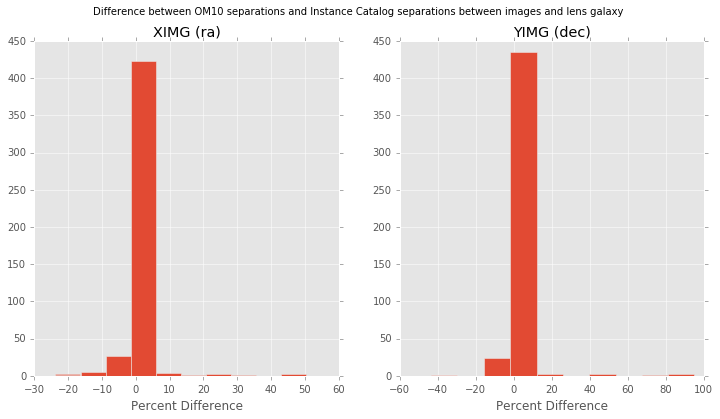

In [8]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1,2,1)
p1 = plt.hist(100*(np.array(x_sep_inst) - np.array(x_sep_om10))/np.array(x_sep_om10))
plt.xlabel('Percent Difference')
plt.title('XIMG (ra)')
fig.add_subplot(1,2,2)
p2 = plt.hist(100*(np.array(y_sep_inst) - np.array(y_sep_om10))/np.array(y_sep_om10))
plt.xlabel('Percent Difference')
plt.title('YIMG (dec)')
plt.suptitle('Difference between OM10 separations and Instance Catalog separations between images and lens galaxy')

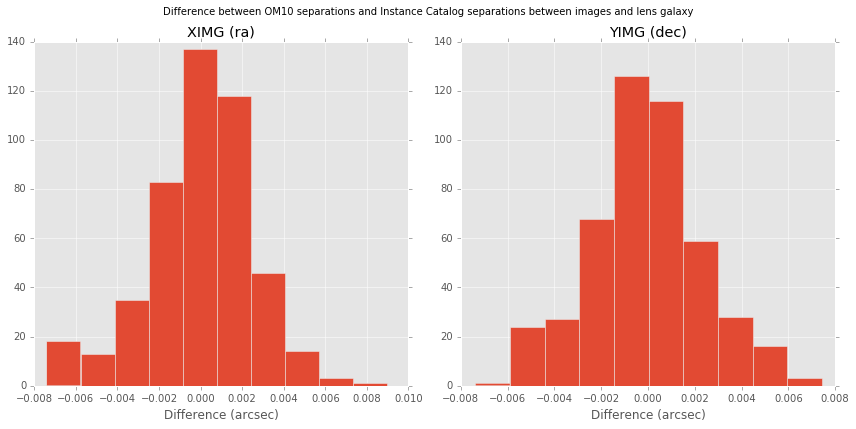

In [9]:
fig = plt.figure(figsize=(12, 6))
fig.add_subplot(1,2,1)
p1 = plt.hist((np.array(x_sep_inst) - np.array(x_sep_om10)))
plt.xlabel('Difference (arcsec)')
plt.title('XIMG (ra)')
fig.add_subplot(1,2,2)
p2 = plt.hist((np.array(y_sep_inst) - np.array(y_sep_om10)))
plt.xlabel('Difference (arcsec)')
plt.title('YIMG (dec)')
plt.suptitle('Difference between OM10 separations and Instance Catalog separations between images and lens galaxy')
plt.tight_layout()
plt.subplots_adjust(top=.9)

Overall, most differences in between the instance catalogs and the OM10 inputs seem to be within 20% and this may be due to rounding errors converting back and forth with such small values in numpy's radians and degrees methods. It seems overall that the positions in the instance catalog are accurate reproductions of the OM10 data they are based upon.

### Check distributions of Lens galaxies

In the next section we will plot the properties of the lens galaxies in the sprinkled data.

In [10]:
twinkles_lens_gals = galaxy_cat[galaxy_cat['id'].isin(sprinkled_agn['lens_gal_id'])].reset_index(drop=True)

In [11]:
ellip = np.sqrt(1-((twinkles_lens_gals['minor_axis']**2)/(twinkles_lens_gals['major_axis']**2)))
twinkles_lens_gals['r_eff'] = twinkles_lens_gals['major_axis']*np.sqrt(1-ellip)

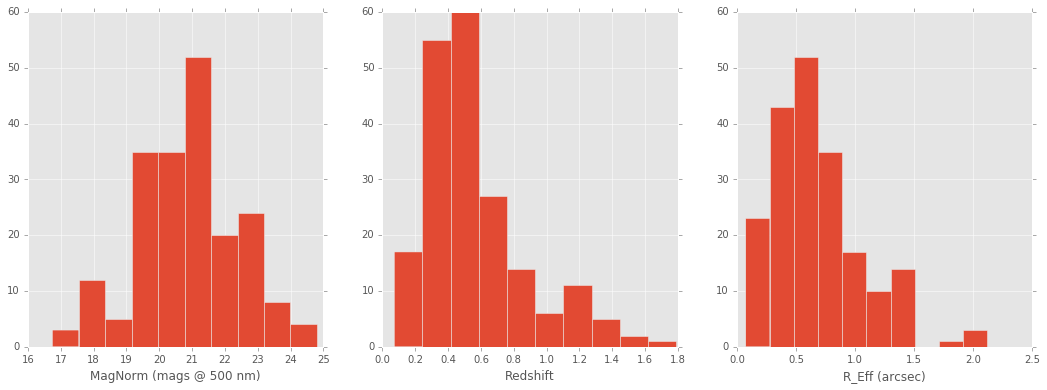

In [12]:
fig = plt.figure(figsize=(18,6))
fig.add_subplot(1,3,1)
p1 = plt.hist(twinkles_lens_gals['mag_norm'])
plt.xlabel('MagNorm (mags @ 500 nm)')
fig.add_subplot(1,3,2)
p2 = plt.hist(twinkles_lens_gals['redshift'])
plt.xlabel('Redshift')
fig.add_subplot(1,3,3)
p3 = plt.hist(twinkles_lens_gals['r_eff'])
plt.xlabel('R_Eff (arcsec)')

### Check distributions of Lensed AGN

Now we plot the properties of the lensed AGN sprinkled into the instance catalogs.

In [13]:
#Use only the brightest AGN image in a system for magnitudes and only record the redshift once for each system
agn_magnorm = {}
agn_redshifts = []
for agn_row in range(len(sprinkled_agn)):
    lens_gal_current = sprinkled_agn['lens_gal_id'][agn_row]
    im_num_current = sprinkled_agn['image_num'][agn_row]
    om10_current = om10_cat[om10_cat['twinklesId'] == twinkles_current]
    try:
        current_val = agn_magnorm[str(lens_gal_current)]
        if sprinkled_agn['mag_norm'][agn_row] < current_val:
            agn_magnorm[str(lens_gal_current)] = sprinkled_agn['mag_norm'][agn_row]
    except KeyError:
        agn_magnorm[str(lens_gal_current)] = sprinkled_agn['mag_norm'][agn_row]
        agn_redshifts.append(sprinkled_agn['redshift'][agn_row])

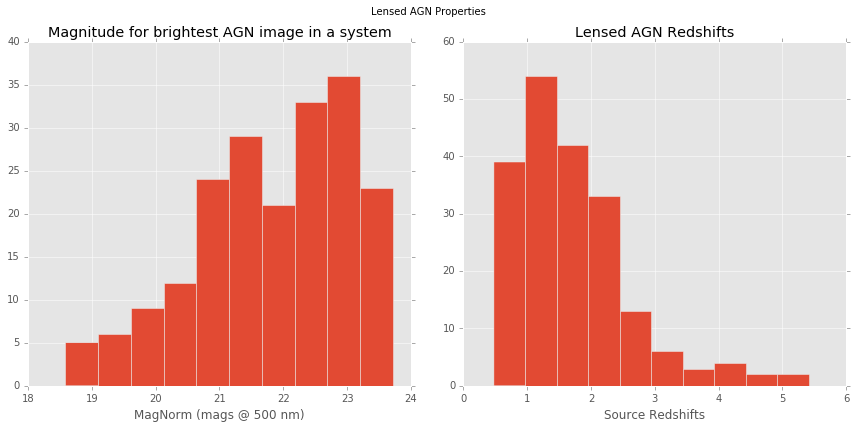

In [14]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.hist(agn_magnorm.values())
plt.title('Magnitude for brightest AGN image in a system')
plt.xlabel('MagNorm (mags @ 500 nm)')
fig.add_subplot(1,2,2)
plt.hist(agn_redshifts)
plt.title('Lensed AGN Redshifts')
plt.xlabel('Source Redshifts')
plt.suptitle('Lensed AGN Properties')
plt.tight_layout()
plt.subplots_adjust(top=.9)

### Varaibility Validation

Finally, we take a look to make sure that the magnitudes for the AGN are not static. We do that by looking at the AGN in two more r band visits from the Twinkles simulation. The AGN from these instance catalogs are located [here](https://gist.github.com/jbkalmbach/5a85bf28d42b34d0f80ddb4b47a65ad7) and [here](https://gist.github.com/jbkalmbach/04ca3e2682a9d6d330763ac84df8a2f2).

In [15]:
agn_cat_2 = pd.read_csv('phosim_agn_185870.txt', delimiter=' ', usecols=(1, 2, 3, 4, 6), names=['id', 'ra', 'dec', 'mag_norm', 'redshift'])
agn_cat_3 = pd.read_csv('phosim_agn_195056.txt', delimiter=' ', usecols=(1, 2, 3, 4, 6), names=['id', 'ra', 'dec', 'mag_norm', 'redshift'])

In [16]:
sprinkled_agn_2 = agn_cat_2.query('id > 1e11').reset_index(drop=True)
sprinkled_agn_3 = agn_cat_3.query('id > 1e11').reset_index(drop=True)

In [17]:
sprinkled_agn['mag_norm_185870'] = sprinkled_agn_2['mag_norm']
sprinkled_agn['mag_norm_195056'] = sprinkled_agn_3['mag_norm']

In [18]:
#Check if the mag_norm value stays the same from the first visit to the second for any AGN image
for agn_row in range(len(sprinkled_agn)):
    if sprinkled_agn['mag_norm'][agn_row] == sprinkled_agn['mag_norm_185870'][agn_row]:
        print agn_row

As the previous cell shows there are no AGN with the same magnitude from the first visit to the next showing that variability is being calculated for each system. Below we plot a few light curves on the set of three visits.

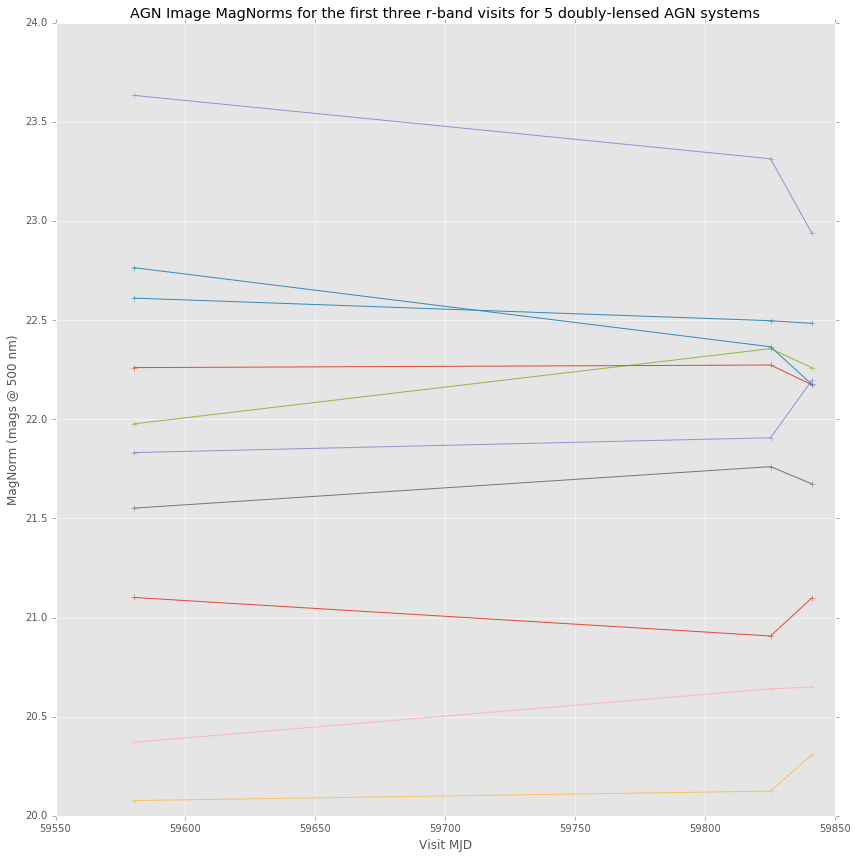

In [19]:
fig = plt.figure(figsize=(12,12))
for agn_row in range(10):
    plt.plot([59580.1, 59825.3, 59841.2], [sprinkled_agn['mag_norm'][agn_row], 
                            sprinkled_agn['mag_norm_185870'][agn_row], 
                            sprinkled_agn['mag_norm_195056'][agn_row]], marker='+')
plt.xlabel('Visit MJD')
plt.ylabel('MagNorm (mags @ 500 nm)')
plt.title('AGN Image MagNorms for the first three r-band visits for 5 doubly-lensed AGN systems')
plt.tight_layout()